In [64]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [65]:
import numpy as np
import pandas as pd
import os
import pickle
import time
import datetime
import gc
import warnings
warnings.filterwarnings("ignore")
import json

In [66]:
main_path = r'../..'
data_path = main_path+'/data'

In [84]:
def reduce_memory_usage(df):
    '''
    iterate through all the columns of a dataframe and modify the data type
    to reduce memory usage.
    '''
    start_mem = df.memory_usage().sum()/1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if (col_type != object) & (col_type != 'datetime64[ns]'):
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum()/1024**2
    print('Memory usage: Before|{:.2f} MB || After|{:.2f} MB || Decreased|{:.1f}%'.format(start_mem, end_mem, 100*(1 - end_mem/start_mem)))
    
    return df 

In [67]:
import multiprocess as mp
 

In [68]:
import sys
sys.path.append(main_path)
from BayDS import *
# from lib.training import plot_importance

In [69]:
# with pd.HDFStore('./hdf/Store.h5',complib='blosc:blosclz') as store:
#     categorial_features = list(store['initial/categorial_features'].values.flatten())
#     numerical_features = list(store['initial/numerical_features'].values.flatten())
categorial_features = json.load(open(f'{data_path}/categorial_features.json','r'))
numerical_features = json.load(open(f'{data_path}/numerical_features.json','r'))

In [70]:
with pd.HDFStore(f'{data_path}/pre-aggregate-no-duplicates.h5') as store:
    data = store[f'data']


In [71]:
def aggregate_with_time(data, group_column,num_feature, window_size=5):
    data_slice = data[['Date',group_column,num_feature]].reset_index()
    gb = data_slice.groupby([group_column])
    q = gb.rolling(window_size,on='Date', min_periods=1)[num_feature].agg(['mean','std'])
    ds = data_slice.set_index(['card_id','Date'])
    ds = ds.join(q)
    ds = ds.set_index('TransactionID').sort_index()
    to_mean = ds[num_feature] / ds['mean']
    to_std = ds[num_feature] / ds['std']
    df = pd.DataFrame(index=data.index)
    df[f'{num_feature}_by_{group_column}_ws{window_size}_to_mean'] = to_mean
    df[f'{num_feature}_by_{group_column}_ws{window_size}_to_std'] = to_std
    return df
    

In [57]:
def aggregate_with_time_local1(args):
    import pandas as pd
    data_slice, group_column, num_feature, window_size = args
    #     data_slice = data[['Date',group_column,num_feature]].reset_index()
    gb = data_slice.groupby([group_column])
    q = gb.rolling(window_size, on='Date', min_periods=1)[num_feature].agg(['mean', 'std'])
    ds = data_slice.set_index(['card_id', 'Date'])
    ds = ds.join(q)
    ds = ds.set_index('TransactionID').sort_index()
    to_mean = ds[num_feature] / ds['mean']
    to_std = ds[num_feature] / ds['std']
    df = pd.DataFrame()
    df[f'{num_feature}_by_{group_column}_ws{window_size}_to_mean'] = to_mean
    df[f'{num_feature}_by_{group_column}_ws{window_size}_to_std'] = to_std
    return df

with mp.Pool(3) as Pool:
#     started = False
    for nf in numerical_features:
#         if nf == 'V1':
#             started=True
#         if not started:
#             continue
        if nf not in data.columns:
            continue
        print(nf)
        df = pd.DataFrame(index=data.index)
        data_slice = data[['Date', 'card_id',nf]].reset_index()
        args = [(data_slice, 'card_id', nf, ws) for ws in ['1d','2d','3d','7d','30d',5,10,100]]
        m = Pool.imap(aggregate_with_time_local1, args)
        for i,df_agg in enumerate(m):
            print('.')
            df = pd.concat([df, df_agg], axis=1)
#         df = pd.concat(m, axis=1)
#         df['TransactionID'] = data_slice['TransactionID']
#         df.set_index('TransactionID')
        df.to_pickle(f'{data_path}/agg1/{nf}.pkl')
#         break


id_01
.
.
.
.
.
.
.
.
id_02
.
.
.
.
.
.
.
.
id_03
.
.
.
.
.
.
.
.
id_04
.
.
.
.
.
.
.
.
id_05
.
.
.
.
.
.
.
.
id_06
.
.
.
.
.
.
.
.
id_07
.
.
.
.
.
.
.
.
id_08
.
.
.
.
.
.
.
.
id_09
.
.
.
.
.
.
.
.
id_10
.
.
.
.
.
.
.
.
id_11
.
.
.
.
.
.
.
.
V3
.
.
.
.
.
.
.
.
V4
.
.
.
.
.
.
.
.
V5
.
.
.
.
.
.
.
.
V6
.
.
.
.
.
.
.
.
V7
.
.
.
.
.
.
.
.
V8
.
.
.
.
.
.
.
.
V9
.
.
.
.
.
.
.
.
V10
.
.
.
.
.
.
.
.
V11
.
.
.
.
.
.
.
.
V12
.
.
.
.
.
.
.
.
V13
.
.
.
.
.
.
.
.
V17
.
.
.
.
.
.
.
.
V19
.
.
.
.
.
.
.
.
V20
.
.
.
.
.
.
.
.
V29
.
.
.
.
.
.
.
.
V30
.
.
.
.
.
.
.
.
V33
.
.
.
.
.
.
.
.
V34
.
.
.
.
.
.
.
.
V35
.
.
.
.
.
.
.
.
V36
.
.
.
.
.
.
.
.
V37
.
.
.
.
.
.
.
.
V38
.
.
.
.
.
.
.
.
V40
.
.
.
.
.
.
.
.
V44
.
.
.
.
.
.
.
.
V45
.
.
.
.
.
.
.
.
V46
.
.
.
.
.
.
.
.
V47
.
.
.
.
.
.
.
.
V48
.
.
.
.
.
.
.
.
V49
.
.
.
.
.
.
.
.
V51
.
.
.
.
.
.
.
.
V52
.
.
.
.
.
.
.
.
V53
.
.
.
.
.
.
.
.
V54
.
.
.
.
.
.
.
.
V56
.
.
.
.
.
.
.
.
V58
.
.
.
.
.
.
.
.
V59
.
.
.
.
.
.
.
.
V60
.
.
.
.
.
.
.
.
V61
.
.
.
.
.
.
.
.
V62
.

ValueError: Only 1-dimensional input arrays are supported.

In [83]:
del df, df_agg, data_slice, agg1, agg2
gc.collect()

1254

In [85]:
timeaggs = pd.DataFrame(index=data.index)

for i, nf in enumerate(numerical_features):
    if nf not in data.columns:
        continue
    print(i, '/', len(numerical_features))
    timeaggs = pd.concat([timeaggs, reduce_mem_usage(pd.read_pickle(f'{data_path}/agg1/{nf}.pkl'))], axis=1)


0 / 388
Mem. usage decreased to 92.08 Mb (35.3% reduction)
1 / 388
Mem. usage decreased to 92.08 Mb (35.3% reduction)
2 / 388
Mem. usage decreased to 142.31 Mb (0.0% reduction)
3 / 388
Mem. usage decreased to 92.08 Mb (35.3% reduction)
4 / 388
Mem. usage decreased to 142.31 Mb (0.0% reduction)
5 / 388
Mem. usage decreased to 92.08 Mb (35.3% reduction)
6 / 388
Mem. usage decreased to 142.31 Mb (0.0% reduction)
7 / 388
Mem. usage decreased to 92.08 Mb (35.3% reduction)
8 / 388
Mem. usage decreased to 142.31 Mb (0.0% reduction)
9 / 388
Mem. usage decreased to 92.08 Mb (35.3% reduction)
10 / 388
Mem. usage decreased to 92.08 Mb (35.3% reduction)
13 / 388
Mem. usage decreased to 92.08 Mb (35.3% reduction)
14 / 388
Mem. usage decreased to 92.08 Mb (35.3% reduction)
15 / 388
Mem. usage decreased to 92.08 Mb (35.3% reduction)
16 / 388
Mem. usage decreased to 92.08 Mb (35.3% reduction)
17 / 388
Mem. usage decreased to 92.08 Mb (35.3% reduction)
18 / 388
Mem. usage decreased to 92.08 Mb (35.3% r

MemoryError: Unable to allocate array with shape (944, 1097231) and data type float64

In [ ]:
timeaggs.shape

In [ ]:
timeaggs = pd.DataFrame(index=data.index)

for i, nf in enumerate(numerical_features):
    if nf not in data.columns:
        continue
    print(i, '/', len(numerical_features))
    timeaggs = pd.concat([timeaggs, reduce_mem_usage(pd.read_pickle(f'{data_path}/agg1/{nf}.pkl'))], axis=1)


In [ ]:
def quick_score_anya(X_new, categorial_features, colname=None, replacement=None, target='isFraud', drop_columns=['Date'], filter_neg_target=True,
                isReplacementCategorial=False, params=None, n_estimators = 6):
    if params is None:
        params = {'num_leaves': 500,
                  'min_child_weight': 0.03454472573214212,
                  'feature_fraction': 0.3797454081646243,
                  'bagging_fraction': 0.4181193142567742,
                  'min_data_in_leaf': 106,
                  'objective': 'binary',
                  'max_depth': -1,
                  'learning_rate': 0.1,
                  "boosting_type": "gbdt",
                  "bagging_seed": 11,
                  "metric": 'auc',
                  "verbosity": -1,
                  'reg_alpha': 0.3899927210061127,
                  'reg_lambda': 0.6485237330340494,
                  'random_state': 47,
                  }


#     X_new = data.loc[train_subset_ids].drop(drop_columns + [target], axis=1)
#     if colname is not None:
#         assert replacement is not None
#         X_new[colname] = replacement.loc[train_subset_ids]
#     y = data.loc[train_subset_ids][target]

    folds = KFold(n_splits=5, shuffle=False)

    if isReplacementCategorial:
        raise Exception("Add replacement column as categorial")

    categorical_columns = [c for c, col in enumerate(X_new.columns) if col in categorial_features]

    params['categorical_feature'] = categorical_columns

    results = train_model_classification(X=X_new, X_test=None, y=y, params=params, folds=folds, splits=1,
                                         model_type='lgb', eval_metric='auc', plot_feature_importance=True,
                                         verbose=None, early_stopping_rounds=40, n_estimators=600, averaging='usual',
                                         n_jobs=-1)

    return sum(results['scores']) / len(results['scores']), results

experiment_name = '31.08'
main_learning_folder = main_path+'/Snapshots/'+experiment_name

y = pd.read_pickle(f'{main_learning_folder}/train.pkl').sort_values('TransactionDT')['isFraud'].astype(np.uint8)

In [124]:
agg1 = reduce_mem_usage(pd.read_pickle(f'{data_path}/agg1/C1.pkl'))

Mem. usage decreased to 92.08 Mb (35.3% reduction)


In [127]:
agg3 = reduce_mem_usage(pd.read_pickle(f'{data_path}/agg1/V3.pkl'))

Mem. usage decreased to 92.08 Mb (35.3% reduction)


In [126]:
agg2 = reduce_mem_usage(pd.read_pickle(f'{data_path}/agg1/TransactionAmt.pkl'))

Mem. usage decreased to 92.08 Mb (35.3% reduction)


Fold 5 started at Mon Sep  9 16:41:01 2019
CV mean score: 0.7419, std: 0.0000.


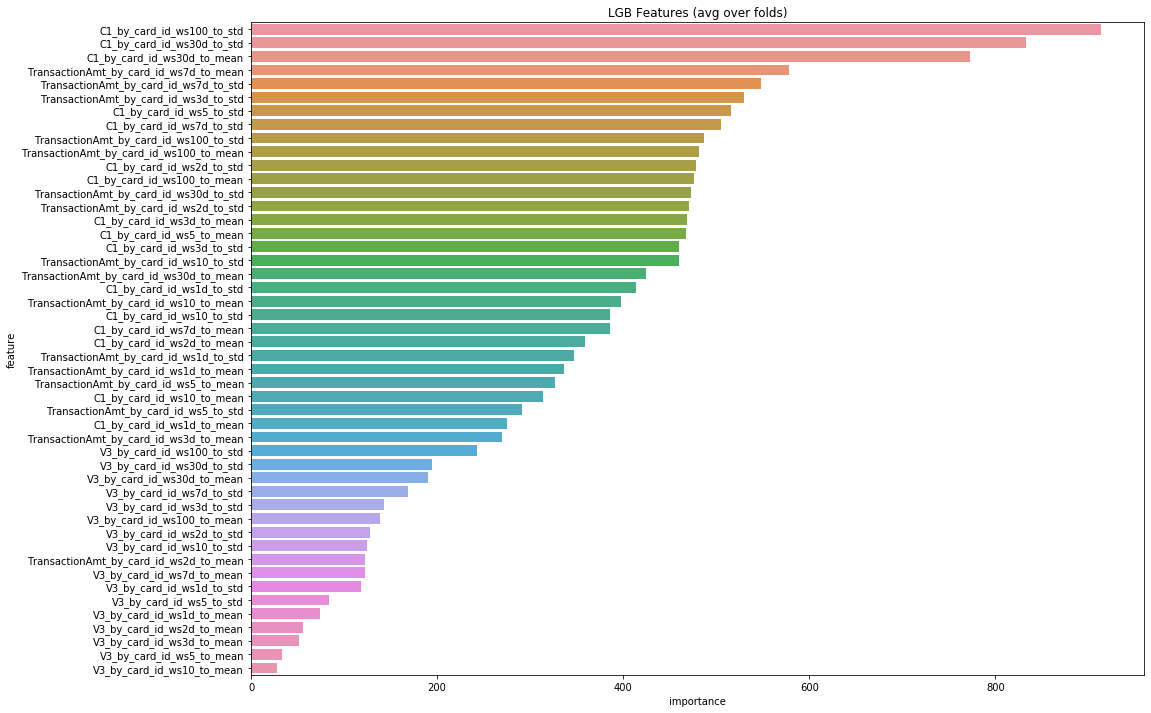

In [128]:
a, res = quick_score_anya(pd.concat([agg1, agg2, agg3], axis=1).loc[:3577539], y)

In [130]:
res['feature_importance'].sort_values(by='importance', ascending=False)

,feature,importance,fold
15,C1_by_card_id_ws100_to_std,914.0,5
9,C1_by_card_id_ws30d_to_std,833.0,5
8,C1_by_card_id_ws30d_to_mean,773.0,5
22,TransactionAmt_by_card_id_ws7d_to_mean,578.0,5
23,TransactionAmt_by_card_id_ws7d_to_std,548.0,5
21,TransactionAmt_by_card_id_ws3d_to_std,530.0,5
11,C1_by_card_id_ws5_to_std,516.0,5
7,C1_by_card_id_ws7d_to_std,505.0,5
31,TransactionAmt_by_card_id_ws100_to_std,487.0,5
30,TransactionAmt_by_card_id_ws100_to_mean,481.0,5


In [147]:
full, fullres = quick_score_anya(timeaggs.loc[:3577539].iloc[:, :100], y)

MemoryError: Unable to allocate array with shape (944, 590540) and data type float64

In [87]:
timeaggs.shape

(1097231, 1824)

In [95]:
timeaggs.shape

(1097231, 1824)

In [94]:
timeaggs.to_pickle(f'{data_path}/timeaggs114feats.pkl')

TypeError: __init__() missing 2 required positional arguments: 'shape' and 'dtype'

In [93]:
del data
gc.collect()

5536

In [88]:
def missing_values_table(df):
    '''
    Функция возвращает таблицу с количеством и долей пропущенных значений в датафрейме
    '''
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})

    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)

    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")
    return mis_val_table_ren_columns

In [118]:
missing_values_table(timeaggs)

KeyboardInterrupt: 